In [31]:
# # -*- coding: utf-8 -*-
# import random
# import copy

# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, SubsetRandomSampler
# from torchvision import datasets, transforms

# # ------------------------------------------------------------------------------
# # Utilitaires de génération d'intervalles
# def merge_intervals(intervals):
#     if not intervals:
#         return []
#     intervals.sort()
#     merged = [intervals[0]]
#     for curr in intervals[1:]:
#         last = merged[-1]
#         if curr[0] <= last[1]:
#             merged[-1] = (last[0], max(last[1], curr[1]))
#         else:
#             merged.append(curr)
#     return merged

# def generate_gaussian_availability(T, wid, n_workers,
#                                    std_dev_ratio=0.065, min_pt=3,
#                                    smooth=10):
#     peaks = [0.2, 0.5, 0.8]
#     sd = int(std_dev_ratio * T)
#     periods = []
#     for m in peaks:
#         mu = int(m * T)
#         start = int(np.random.normal(mu, sd))
#         start = max(0, min(start, T - min_pt*3))
#         dur = random.randint(min_pt*3, min(min_pt*5, T - start))
#         periods.append((start, start + dur))
#     merged = merge_intervals(periods)
#     return merge_intervals([(max(0, s - smooth), min(T, e + smooth))
#                              for s,e in merged])

# def generate_gaussian_byzantine_availability(T, wid, n_workers,
#                                              std_dev_ratio=0.06, min_pt=3,
#                                              smooth=10):
#     peaks = [0.08, 0.9]
#     sd = int(std_dev_ratio * T)
#     periods = []
#     for m in peaks:
#         mu = int(m * T)
#         start = int(np.random.normal(mu, sd))
#         start = max(0, min(start, T - min_pt*4))
#         dur = random.randint(min_pt*4, min(min_pt*8, T - start))
#         periods.append((start, start + dur))
#     merged = merge_intervals(periods)
#     return merge_intervals([(max(0, s - smooth), min(T, e + smooth))
#                              for s,e in merged])

# # ------------------------------------------------------------------------------
# # Modèle LeNet-like
# class LeNetLike(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1,32,3,padding=1)
#         self.conv2 = nn.Conv2d(32,64,3,padding=1)
#         self.pool  = nn.MaxPool2d(2,2)
#         self.fc1   = nn.Linear(64*7*7,128)
#         self.dropout = nn.Dropout(0.25)
#         self.fc2   = nn.Linear(128,10)
#     def forward(self,x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1,64*7*7)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         return self.fc2(x)

# # ------------------------------------------------------------------------------
# # Batch manager cyclique
# class BatchManager:
#     def __init__(self,dataset,bs):
#         self.dataset = dataset
#         self.bs      = bs
#         self._reset()
#     def _reset(self):
#         idx = list(range(len(self.dataset)))
#         random.shuffle(idx)
#         self.sampler = SubsetRandomSampler(idx)
#         self.loader  = iter(DataLoader(self.dataset,batch_size=self.bs,
#                                        sampler=self.sampler))
#     def get_next(self):
#         try:
#             return next(self.loader)
#         except StopIteration:
#             self._reset()
#             return next(self.loader)

# # ------------------------------------------------------------------------------
# # Worker et ByzantineWorker
# class Worker:
#     def __init__(self, model, device, wid, avail, pt):
#         self.is_byzantine = False
#         self.device       = device
#         self.worker_id    = wid
#         self.availability_periods = avail
#         self.pt           = pt
#         self.model        = copy.deepcopy(model).to(device)
#         self.crit         = nn.CrossEntropyLoss()
#         self.finish       = None
#         self.batch_info   = None
#         self.pending      = None

#     def is_available(self, t):
#         for s,e in self.availability_periods:
#             if s<=t<e and (self.finish is None or t>=self.finish):
#                 return (t+self.pt)<=e
#         return False

#     def start(self, t, binfo, data, tgt):
#         if self.batch_info!=binfo:
#             self.batch_info=binfo
#             self.finish    = t+self.pt
#             self.pending   = (data,tgt)

#     def has_finished(self, t):
#         if self.finish==t and self.pending is not None:
#             data,tgt = self.pending
#             self.pending = None
#             grads = self.compute_gradient(data,tgt)
#             return True, grads, self.batch_info
#         return False, None, None

#     def compute_gradient(self,data,tgt):
#         data,tgt = data.to(self.device), tgt.to(self.device)
#         self.model.zero_grad()
#         out = self.model(data)
#         loss= self.crit(out, tgt)
#         loss.backward()
#         return {n:p.grad.detach().clone() 
#                 for n,p in self.model.named_parameters()}

#     def update_model(self, sd):
#         self.model.load_state_dict(sd)

# class ByzantineWorker(Worker):
#     def __init__(self, model, device, wid, avail, pt):
#         super().__init__(model,device,wid,avail,pt)
#         self.is_byzantine = True
#     def compute_gradient(self,data,tgt):
#         honest = super().compute_gradient(data,tgt)
#         mag = random.uniform(1e6,9e6)
#         return {n:torch.full_like(g,mag) for n,g in honest.items()}

# # ------------------------------------------------------------------------------
# # Comparaison pour vote-majorité
# def _gradients_are_equal(g1,g2,rtol=1e-3,atol=1e-8):
#     for k in g1:
#         if not torch.allclose(g1[k],g2[k],rtol=rtol,atol=atol):
#             return False
#     return True

# # ------------------------------------------------------------------------------
# # Serveur principal
# class Server:
#     def __init__(self,dataset,bs=64,mbs=16,lr=5e-3,device=None):
#         self.device   = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.model    = LeNetLike().to(self.device)
#         self.opt      = optim.Adam(self.model.parameters(),lr=lr)
#         self.bm       = BatchManager(dataset,bs)
#         self.mbs      = mbs
#         self.bid      = 0
#         self.mbs_dict = {}
#         self.received = {}
#         # pour chaque bid, liste des pt participants
#         self.current_batch_workers = {}

#     def new_full_batch(self):
#         data,tgt = self.bm.get_next()
#         self.bid +=1
#         n=data.size(0)
#         mbatches=[(data[i:i+self.mbs],tgt[i:i+self.mbs]) 
#                   for i in range(0,n,self.mbs)]
#         self.mbs_dict = {i:mbatches[i] for i in range(len(mbatches))}
#         self.received = {}
#         # init liste pt
#         self.current_batch_workers[self.bid]=[]

#     def register(self,grads,binfo):
#         b,m=binfo
#         if b!=self.bid: return
#         self.received.setdefault(m,[]).append(grads)

#     def aggregate_and_step(self,strategy='average',k=1):
#         final={}
#         for m,glist in self.received.items():
#             if strategy=='average' or len(glist)==1:
#                 final[m]=glist[0]
#             else:
#                 counts=[ sum(_gradients_are_equal(glist[i],glist[j])
#                              for j in range(len(glist)))
#                           for i in range(len(glist)) ]
#                 maxc=max(counts)
#                 cands=[i for i,c in enumerate(counts) if c==maxc]
#                 if len(cands)==1:
#                     sel=cands[0]
#                 else:
#                     norms=[ torch.nn.utils.parameters_to_vector(
#                                 list(glist[i].values())
#                            ).norm().item() for i in cands ]
#                     med=sorted(norms)[len(norms)//2]
#                     sel=cands[norms.index(med)]
#                 final[m]=glist[sel]
#         # mise à jour
#         agg={}
#         for n,p in self.model.named_parameters():
#             stacked=torch.stack([ final[m][n].view(-1)
#                                   for m in sorted(final)])
#             agg[n]=stacked.mean(0).view(p.size())
#         self.opt.zero_grad()
#         for n,p in self.model.named_parameters():
#             p.grad=agg[n]
#         self.opt.step()

#     def eval_acc(self,loader):
#         self.model.eval()
#         correct=total=0
#         with torch.no_grad():
#             for x,t in loader:
#                 x,t=x.to(self.device),t.to(self.device)
#                 out=self.model(x)
#                 correct+=(out.argmax(1)==t).sum().item()
#                 total+=t.size(0)
#         self.model.train()
#         return 100*correct/total

# # ------------------------------------------------------------------------------
# # Simulateur avec Gantt des intervalles
# class SafePointSimulator:
#     def __init__(self,server,workers,val_loader,test_loader,T=20000):
#         self.srv=server
#         self.workers=workers
#         self.val_loader=val_loader
#         self.test_loader=test_loader
#         self.global_time=0
#         self.total_time_steps=T

#         self.batches_since_sp=0
#         self.batch_start_times=[]
#         self.all_batch_times=[]
#         # événements (start, finish)
#         self.useful_events=[]
#         self.waste_events=[]

#     def plot_worker_availability(self): pass

#     def run(self):
#         cycle_size,window_size=6,4
#         n_slopes=cycle_size-window_size+1
#         eps=1e-7

#         cycle_idx,in_cycle_cnt=1,0
#         retried=False
#         strat,k='average',1
#         acc_history=[]
#         cycle_accs={}
#         best=0

#         # safe-point initial
#         safe_states={0:copy.deepcopy(self.srv.model.state_dict())}
#         safe_opts  ={0:copy.deepcopy(self.srv.opt.state_dict())}
#         safe_accs  ={0:self.srv.eval_acc(self.val_loader)}
#         safe_times ={0:self.global_time}
#         print(f"[t={self.global_time}] SP0 — Acc {safe_accs[0]:.2f}%")

#         # premier batch start
#         self.srv.new_full_batch()
#         self.batch_start_times.append(self.global_time)

#         in_prog=[]
#         time_points,acc_over_time=[],[]

#         while self.global_time<self.total_time_steps:
#             # 1) terminer tasks
#             for w in in_prog[:]:
#                 done,grads,binfo=w.has_finished(self.global_time)
#                 if done:
#                     self.srv.register(grads,binfo)
#                     in_prog.remove(w)

#             # 2) assign batches & track pts
#             for m,(data,tgt) in self.srv.mbs_dict.items():
#                 need = k if strat=='majority' else 1
#                 have = len(self.srv.received.get(m,[]))
#                 while have<need:
#                     avail=[w for w in self.workers
#                            if w.is_available(self.global_time) and w not in in_prog]
#                     if not avail: break
#                     w=avail.pop(0)
#                     w.update_model(self.srv.model.state_dict())
#                     w.start(self.global_time,(self.srv.bid,m),data,tgt)
#                     in_prog.append(w)
#                     self.srv.current_batch_workers[self.srv.bid].append(w.pt)
#                     have+=1

#             # 3) aggregate + eval
#             if all(len(self.srv.received.get(m,[])) >= (k if strat=='majority' else 1)
#                    for m in self.srv.mbs_dict):
#                 # compute finish interval
#                 duration = sum(self.srv.current_batch_workers[self.srv.bid])
#                 self.all_batch_times.append(duration)


#                 # agrégation
#                 self.srv.aggregate_and_step(strategy=strat,k=k)
#                 acc=self.srv.eval_acc(self.val_loader)
#                 acc_history.append(acc)
#                 in_cycle_cnt+=1
#                 print(f"[t={self.global_time}] C{cycle_idx} B{in_cycle_cnt} → {acc:.2f}%")

#                 self.batches_since_sp+=1
#                 # next batch start
#                 self.srv.new_full_batch()
#                 self.batch_start_times.append(self.global_time)
#                 in_prog.clear()

#                 # fin cycle1/2 ?
#                 if cycle_idx<=2 and in_cycle_cnt==cycle_size:
#                     cycle_accs[cycle_idx]=acc_history.copy()

#                     # slopes
#                     slopes=[]
#                     for s in range(n_slopes):
#                         y=np.array(acc_history[s:s+window_size])
#                         m_s,_=np.polyfit(np.arange(window_size),y,1)
#                         slopes.append(m_s if abs(m_s)>eps else 0.0)
#                     for i,m_s in enumerate(slopes,1):
#                         print(f"Slope[{i}]={m_s:.4f}")

#                     # rollback1
#                     if cycle_idx==1 and all(m<=0 for m in slopes) and not retried:
#                         print("Rollback1")
#                         # last N intervals => waste
#                         for _ in range(self.batches_since_sp):
#                             s0 = self.batch_start_times.pop(0)
#                             d0 = self.all_batch_times.pop(0)
#                             self.waste_events.append((s0,s0+d0))
#                         self.batches_since_sp=0
#                         self.srv.model.load_state_dict(safe_states[0])
#                         self.srv.opt.load_state_dict(safe_opts[0])
#                         strat,k,retried='majority',4,True
#                         in_cycle_cnt,acc_history=0,[]
#                         continue

#                     # safe-point1
#                     y1=np.array(cycle_accs[1])
#                     m1,_=np.polyfit(np.arange(len(y1)),y1,1)
#                     m1 = m1 if abs(m1)>eps else 0.0
#                     if cycle_idx==1 and m1>0 and acc_history[-1]>safe_accs[0]:
#                         print("SP1 validé")
#                         for _ in range(self.batches_since_sp):
#                             s0=self.batch_start_times.pop(0)
#                             d0=self.all_batch_times.pop(0)
#                             self.useful_events.append((s0,s0+d0))
#                         self.batches_since_sp=0
#                         safe_states[1]=copy.deepcopy(self.srv.model.state_dict())
#                         safe_opts[1]  =copy.deepcopy(self.srv.opt.state_dict())
#                         safe_accs[1]  =acc_history[-1]
#                         safe_times[1] =self.global_time

#                     # rollback2
#                     if cycle_idx==2 and 1 in safe_accs:
#                         slopes2=[]
#                         for s in range(n_slopes):
#                             y2=np.array(acc_history[s:s+window_size])
#                             m2,_=np.polyfit(np.arange(window_size),y2,1)
#                             slopes2.append(m2 if abs(m2)>eps else 0.0)
#                         if all(m2<=0 for m2 in slopes2) and not retried:
#                             print("Rollback2")
#                             for _ in range(self.batches_since_sp):
#                                 s0=self.batch_start_times.pop(0)
#                                 d0=self.all_batch_times.pop(0)
#                                 self.waste_events.append((s0,s0+d0))
#                             self.batches_since_sp=0
#                             self.srv.model.load_state_dict(safe_states[1])
#                             self.srv.opt.load_state_dict(safe_opts[1])
#                             strat,k,retried='majority',4,True
#                             in_cycle_cnt,acc_history=0,[]
#                             continue

#                         # safe-point2
#                         y2all=np.array(cycle_accs[2])
#                         m2all,_=np.polyfit(np.arange(len(y2all)),y2all,1)
#                         m2all=m2all if abs(m2all)>eps else 0.0
#                         if m2all>0 and acc_history[-1]>safe_accs.get(1,0):
#                             print("SP2 validé")
#                             for _ in range(self.batches_since_sp):
#                                 s0=self.batch_start_times.pop(0)
#                                 d0=self.all_batch_times.pop(0)
#                                 self.useful_events.append((s0,s0+d0))
#                             self.batches_since_sp=0
#                             safe_states[2]=copy.deepcopy(self.srv.model.state_dict())
#                             safe_opts[2]  =copy.deepcopy(self.srv.opt.state_dict())
#                             safe_accs[2]  =acc_history[-1]
#                             safe_times[2] =self.global_time

#                     # suivant cycle
#                     cycle_idx,in_cycle_cnt,acc_history=cycle_idx+1,0,[]
#                     strat,k,retried='average',1,False

#             # super safe-point (fin cycle2)
#             if cycle_idx==3:
#                 all_accs=cycle_accs.get(1,[])+cycle_accs.get(2,[])
#                 m_glob,_=np.polyfit(np.arange(len(all_accs)),np.array(all_accs),1)
#                 m_glob=m_glob if abs(m_glob)>eps else 0.0
#                 if m_glob<=0:
#                     best=1 if 1 in safe_accs else 0
#                 else:
#                     cands=[ci for ci in safe_accs if ci>0]
#                     best=max(cands,key=lambda c:safe_accs[c],default=0)
#                 print(f"Super SP → cycle {best}")

#                 # classifier restants
#                 for _ in range(self.batches_since_sp):
#                     s0=self.batch_start_times.pop(0)
#                     d0=self.all_batch_times.pop(0)
#                     if best in (0,1):
#                         self.waste_events.append((s0,s0+d0))
#                     else:
#                         self.useful_events.append((s0,s0+d0))
#                 self.batches_since_sp=0

#                 self.srv.model.load_state_dict(safe_states[best])
#                 self.srv.opt.load_state_dict(safe_opts[best])
#                 cycle_idx,in_cycle_cnt,acc_history=1,0,[]
#                 strat,k,retried='average',1,False
#                 cycle_accs.clear()

#             # test périodique
#             if self.global_time%10==0:
#                 curr_s=copy.deepcopy(self.srv.model.state_dict())
#                 curr_o=copy.deepcopy(self.srv.opt.state_dict())
#                 self.srv.model.load_state_dict(safe_states[best])
#                 self.srv.opt.load_state_dict(safe_opts[best])
#                 at=self.srv.eval_acc(self.test_loader)
#                 acc_over_time.append(at)
#                 time_points.append(self.global_time)
#                 self.srv.model.load_state_dict(curr_s)
#                 self.srv.opt.load_state_dict(curr_o)

#             self.global_time+=1

#         # final
#         self.srv.model.load_state_dict(safe_states[best])
#         self.srv.opt.load_state_dict(safe_opts[best])
#         final_acc=self.srv.eval_acc(self.test_loader)
#         print(f"[t={self.global_time}] Final test Acc: {final_acc:.2f}%")

#         # accuracy curve
#         plt.figure(figsize=(10,5))
#         plt.plot(time_points,acc_over_time,linewidth=2)
#         plt.title("Évolution accuracy")
#         plt.xlabel("Time"); plt.ylabel("Acc (%)")
#         plt.grid('--',alpha=0.4)
#         plt.tight_layout(); plt.show()

#         return time_points, acc_over_time, final_acc

# # ------------------------------------------------------------------------------
# from matplotlib.patches import Rectangle
# def main():
#     NUM_WORKERS=200
#     STEPS=1000
#     BYZ_RATIOS=[0.3]

#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#     ])
#     train_ds = datasets.MNIST('./data',train=True,download=True,transform=transform)
#     test_ds  = datasets.MNIST('./data',train=False,transform=transform)

#     n=len(train_ds)
#     n_val=int(0.2*n)
#     perm=torch.randperm(n)
#     val_idx=perm[:n_val].tolist()
#     val_loader=DataLoader(train_ds,batch_size=200,
#                           sampler=SubsetRandomSampler(val_idx))
#     test_loader=DataLoader(test_ds,batch_size=200,shuffle=False)

#     for byz_ratio in BYZ_RATIOS:
#         # init serveur & workers
#         server=Server(train_ds,bs=360,mbs=36)
#         byz_ids=set(random.sample(range(1,NUM_WORKERS+1),
#                                   int(NUM_WORKERS*byz_ratio)))
#         workers=[]
#         for i in range(1,NUM_WORKERS+1):
#             pt=random.randint(2,10)
#             av=(generate_gaussian_byzantine_availability if i in byz_ids
#                 else generate_gaussian_availability)(
#                     STEPS,i,NUM_WORKERS,min_pt=pt)
#             cls=ByzantineWorker if i in byz_ids else Worker
#             workers.append(cls(server.model,server.device,i,av,pt))

#         sim=SafePointSimulator(server,workers,val_loader,test_loader,T=STEPS)
#         tp,acc_ot,_=sim.run()

      


# if __name__=='__main__':
#     main()


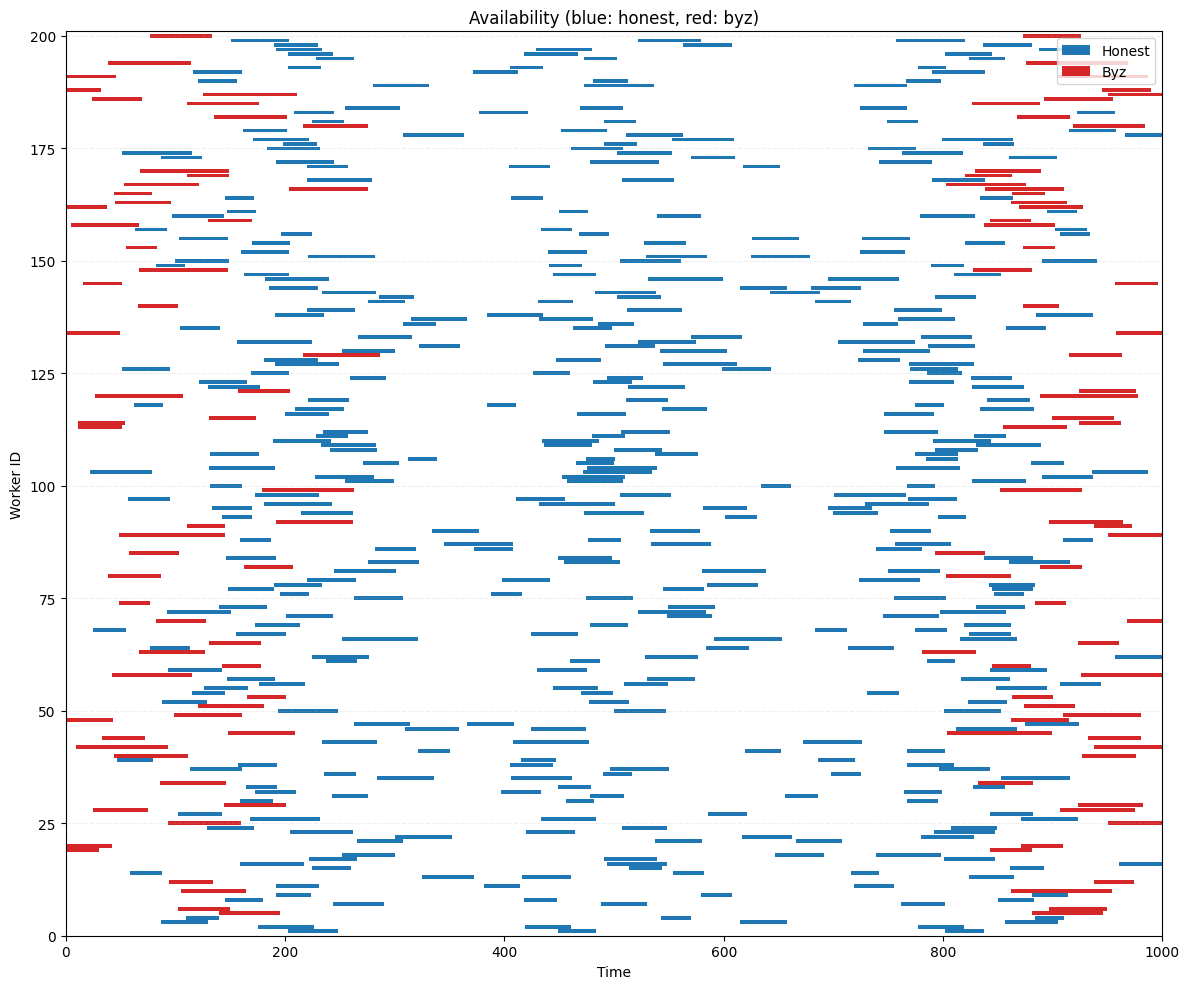

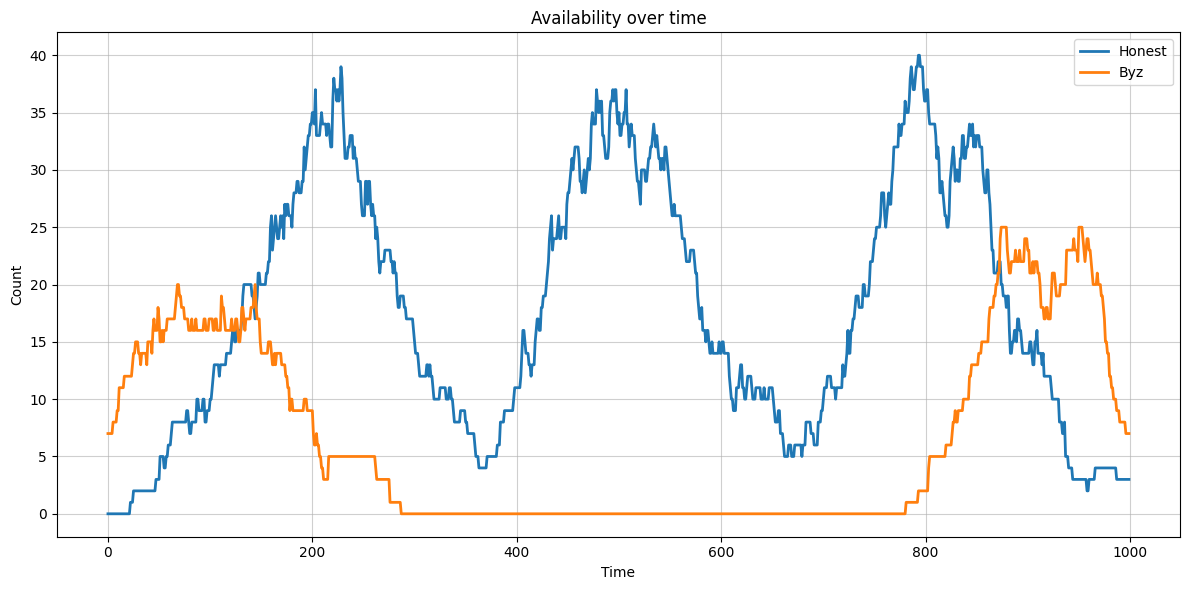

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 9.81%
[t=14] Cycle 1, batch #1 → Acc val: 10.12%


KeyboardInterrupt: 

In [32]:
# -*- coding: utf-8 -*-
import random
import math
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

import byzfl  # vos agrégateurs tiers

# ------------------------------------------------------------------------------
# Utilitaires de génération d'intervalles
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for curr in intervals[1:]:
        last = merged[-1]
        if curr[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], curr[1]))
        else:
            merged.append(curr)
    return merged

def generate_gaussian_availability(T, wid, n_workers,
                                   std_dev_ratio=0.065, min_pt=3,
                                   smooth=10):
    peaks = [0.2, 0.5, 0.8]
    sd = int(std_dev_ratio * T)
    periods = []
    for m in peaks:
        mu = int(m * T)
        start = int(np.random.normal(mu, sd))
        start = max(0, min(start, T - min_pt*3))
        dur = random.randint(min_pt*3, min(min_pt*5, T - start))
        periods.append((start, start + dur))
    merged = merge_intervals(periods)
    return merge_intervals([(max(0,s-smooth), min(T,e+smooth)) for s,e in merged])

def generate_gaussian_byzantine_availability(T, wid, n_workers,
                                             std_dev_ratio=0.06, min_pt=3,
                                             smooth=10):
    peaks = [0.08, 0.9]
    sd = int(std_dev_ratio * T)
    periods = []
    for m in peaks:
        mu = int(m * T)
        start = int(np.random.normal(mu, sd))
        start = max(0, min(start, T - min_pt*4))
        dur = random.randint(min_pt*4, min(min_pt*8, T - start))
        periods.append((start, start + dur))
    merged = merge_intervals(periods)
    return merge_intervals([(max(0,s-smooth), min(T,e+smooth)) for s,e in merged])


# ------------------------------------------------------------------------------
# Modèle LeNet-like
class LeNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1   = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2   = nn.Conv2d(32,64,3,padding=1)
        self.pool    = nn.MaxPool2d(2,2)
        self.fc1     = nn.Linear(64*7*7,128)
        self.dropout = nn.Dropout(0.25)
        self.fc2     = nn.Linear(128,10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


# ------------------------------------------------------------------------------
# Batch manager cyclique
class BatchManager:
    def __init__(self, dataset, bs):
        self.dataset = dataset
        self.bs      = bs
        self._reset()
    def _reset(self):
        idx = list(range(len(self.dataset)))
        random.shuffle(idx)
        self.sampler = SubsetRandomSampler(idx)
        self.loader  = iter(DataLoader(self.dataset, batch_size=self.bs,
                                       sampler=self.sampler))
    def get_next(self):
        try:
            return next(self.loader)
        except StopIteration:
            self._reset()
            return next(self.loader)


# ------------------------------------------------------------------------------
# Worker et ByzantineWorker
class Worker:
    def __init__(self, model, device, wid, avail, pt):
        self.is_byzantine = False
        self.device       = device
        self.worker_id          = wid
        self.availability_periods        = avail
        self.pt           = pt
        self.model        = copy.deepcopy(model).to(device)
        self.crit         = nn.CrossEntropyLoss()
        self.finish       = None
        self.batch_info   = None
        self.pending      = None

    def is_available(self, t):
        for s,e in self.availability_periods:
            if s <= t < e and (self.finish is None or t >= self.finish):
                return (t + self.pt) <= e
        return False

    def start(self, t, binfo, data, tgt):
        if self.batch_info != binfo:
            self.batch_info = binfo
            self.finish     = t + self.pt
            self.pending    = (data, tgt)

    def has_finished(self, t):
        if self.finish == t and self.pending is not None:
            data, tgt = self.pending
            self.pending = None
            grads = self.compute_gradient(data, tgt)
            return True, grads, self.batch_info
        return False, None, None

    def compute_gradient(self, data, tgt):
        data, tgt = data.to(self.device), tgt.to(self.device)
        self.model.zero_grad()
        out = self.model(data)
        loss = self.crit(out, tgt)
        loss.backward()
        return {n: p.grad.detach().clone()
                for n,p in self.model.named_parameters()}

    def update_model(self, sd):
        self.model.load_state_dict(sd)


class ByzantineWorker(Worker):
    def __init__(self, model, device, wid, avail, pt):
        super().__init__(model, device, wid, avail, pt)
        self.is_byzantine = True

    def compute_gradient(self, data, tgt):
        honest = super().compute_gradient(data, tgt)
        #if random.random() < 0.5:
        mag = random.uniform(1e6, 9e6)
        return {n: torch.full_like(g, mag) for n,g in honest.items()}
        # flats, shapes = [], []
        # for n,g in honest.items():
        #     flats.append(g.view(-1))
        #     shapes.append((n, g.shape))
        # g = torch.cat(flats)
        # r = torch.randn_like(g)
        # proj = (torch.dot(g, r)/torch.dot(g, g))*g if torch.dot(g, g)>0 else torch.zeros_like(g)
        # u = r - proj
        # if u.norm()>0:
        #     u = u * (g.norm()/u.norm())
        # θ  = random.uniform(math.pi/2, 3*math.pi/2)
        # cv = math.cos(θ)*g + math.sin(θ)*u
        # corr = {}
        # idx  = 0
        # for n, sh in shapes:
        #     num = int(torch.tensor(sh).prod().item())
        #     corr[n] = cv[idx:idx+num].view(sh)
        #     idx += num
        #return corr


# ------------------------------------------------------------------------------
# Comparaison pour vote-majorité
def _gradients_are_equal(g1, g2, rtol=1e-3, atol=1e-8):
    for k in g1:
        if not torch.allclose(g1[k], g2[k], rtol=rtol, atol=atol):
            return False
    return True


# ------------------------------------------------------------------------------
# Serveur principal
class Server:
    def __init__(self, dataset, bs=64, mbs=16, lr=5e-3, device=None):
        self.device      = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model       = LeNetLike().to(self.device)
        self.opt         = optim.Adam(self.model.parameters(), lr=lr)
        self.bm          = BatchManager(dataset, bs)
        self.mbs         = mbs
        self.bid         = 0
        self.mbs_dict    = {}
        self.received    = {}
        self.crit        = nn.CrossEntropyLoss()

    def new_full_batch(self):
        data, tgt = self.bm.get_next()
        self.bid += 1
        n = data.size(0)
        mbatches = [(data[i:i+self.mbs], tgt[i:i+self.mbs])
                    for i in range(0, n, self.mbs)]
        self.mbs_dict = {i: mbatches[i] for i in range(len(mbatches))}
        self.received = {}

    def register(self, grads, binfo):
        b, m = binfo
        if b != self.bid:
            return
        self.received.setdefault(m, []).append(grads)

    def aggregate_and_step(self, strategy='average', k=1):
        final = {}
        for m, glist in self.received.items():
            if strategy == 'average' or len(glist) == 1:
                final[m] = glist[0]
            else:
                # vote-majorité
                counts = [0]*len(glist)
                for i in range(len(glist)):
                    for j in range(len(glist)):
                        if _gradients_are_equal(glist[i], glist[j]):
                            counts[i] += 1
                maxc  = max(counts)
                cands = [i for i,c in enumerate(counts) if c==maxc]
                if len(cands) == 1:
                    sel = cands[0]
                else:
                    norms = [
                        torch.nn.utils.parameters_to_vector(list(glist[i].values())).norm().item()
                        for i in cands
                    ]
                    med_idx = norms.index(sorted(norms)[len(norms)//2])
                    sel     = cands[med_idx]
                final[m] = glist[sel]

        # moyenne classique
        agg = {}
        for n,p in self.model.named_parameters():
            stacked = torch.stack([ final[m][n].view(-1)
                                    for m in sorted(final) ])
            agg[n] = stacked.mean(dim=0).view(p.size())
        self.opt.zero_grad()
        for n,p in self.model.named_parameters():
            p.grad = agg[n]
        self.opt.step()

    def eval_acc(self, loader):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for x,t in loader:
                x,t   = x.to(self.device), t.to(self.device)
                out   = self.model(x)
                correct += (out.argmax(1)==t).sum().item()
                total   += t.size(0)
        self.model.train()
        return 100 * correct / total


# ------------------------------------------------------------------------------
# Simulateur asynchrone avec sliding‐window et rollback
class SafePointSimulator:
    def __init__(self, server, workers, val_loader, test_loader, T=20000):
        self.srv                  = server
        self.workers              = workers
        self.val_loader           = val_loader
        self.test_loader          = test_loader
        self.global_time          = 0
        self.total_time_steps     = T
        # dicts to record times and processing sums for each full batch
        self.batch_request_times  = {}
        self.batch_finish_times   = {}
        self.batch_proc_times     = {}
        # to track batch IDs per cycle and classify waste/useful
        self.cycle_batches        = {}
        self.wasted_batches       = []
        self.useful_batches       = []
        self.plot_worker_availability()

    def run(self):
        cycle_size    = 6
        window_size   = 4
        n_slopes      = cycle_size - window_size + 1
        THRESHOLD     = 1e-7

        cycle_idx     = 1
        in_cycle_cnt  = 0
        retried       = False
        k             = 6
        strat         = 'average'
        acc_history   = []
        cycle_accs    = {}
        best          = 0

        # safe-point initial (cycle 0)
        safe_states = {0: copy.deepcopy(self.srv.model.state_dict())}
        safe_opts   = {0: copy.deepcopy(self.srv.opt.state_dict())}
        safe_accs   = {0: self.srv.eval_acc(self.val_loader)}
        safe_times  = {0: self.global_time}
        print(f"[t={self.global_time}] = Safe-point ACTUEL cycle 0 — Acc: {safe_accs[0]:.2f}%")

        base_state_cycle1 = None
        base_opt_cycle1   = None

        self.srv.new_full_batch()
        in_prog       = []
        acc_over_time = []
        time_points   = []

        while self.global_time < self.total_time_steps:
            # 1) terminer les tasks arrivées
            for w in in_prog[:]:
                done, grads, binfo = w.has_finished(self.global_time)
                if done:
                    self.srv.register(grads, binfo)
                    in_prog.remove(w)

            # 2) assigner les mini-batches
            for m, (data, tgt) in self.srv.mbs_dict.items():
                need = k if strat == 'majority' else 1
                have = len(self.srv.received.get(m, []))
                while have < need:
                    avail = [w for w in self.workers
                             if w.is_available(self.global_time) and w not in in_prog]
                    if not avail:
                        break
                    bid = self.srv.bid
                    if bid not in self.batch_request_times:
                        self.batch_request_times[bid] = self.global_time
                        self.batch_proc_times[bid]    = 0
                    w = avail.pop(0)
                    self.batch_proc_times[bid] += w.pt
                    w.update_model(self.srv.model.state_dict())
                    w.start(self.global_time, (bid, m), data, tgt)
                    in_prog.append(w)
                    have += 1

            # 3) agrégation + éval dès réception de tous les gradients
            if all(len(self.srv.received.get(m, [])) >= (k if strat=='majority' else 1)
                   for m in self.srv.mbs_dict):
                bid = self.srv.bid
                self.batch_finish_times[bid] = self.global_time
                self.cycle_batches.setdefault(cycle_idx, []).append(bid)

                self.srv.aggregate_and_step(strategy=strat, k=k)
                acc = self.srv.eval_acc(self.val_loader)
                acc_history.append(acc)
                in_cycle_cnt += 1
                print(f"[t={self.global_time}] Cycle {cycle_idx}, batch #{in_cycle_cnt} → Acc val: {acc:.2f}%")

                self.srv.new_full_batch()
                in_prog.clear()

                if cycle_idx <= 2 and in_cycle_cnt == cycle_size:
                    cycle_accs[cycle_idx] = acc_history.copy()
                    # fin cycle 1: sauvegarde pour rollback cycle 2
                    if cycle_idx == 1:
                        base_state_cycle1 = copy.deepcopy(self.srv.model.state_dict())
                        base_opt_cycle1   = copy.deepcopy(self.srv.opt.state_dict())
                        print(f"[t={self.global_time}] = Base rollback pour cycle 2 mise à jour")
                        slopes = []
                        for s in range(n_slopes):
                            y = np.array(acc_history[s:s+window_size])
                            m_slope, _ = np.polyfit(np.arange(window_size), y, 1)
                            m_slope = 0.0 if abs(m_slope) < THRESHOLD else m_slope
                            slopes.append(m_slope)
                        if all(m <= 0 for m in slopes) and not retried:
                            print(f"[t={self.global_time}] Rollback cycle 1 → vote-majorité")
                            wasted = self.cycle_batches.get(1, [])
                            print(f"Waste batches cycle 1: {wasted}")
                            self.wasted_batches.extend(wasted)
                            self.cycle_batches[1] = []
                            self.srv.model.load_state_dict(safe_states[0])
                            self.srv.opt.load_state_dict(safe_opts[0])
                            retried = True
                            in_cycle_cnt = 0
                            acc_history.clear()
                            print(f"[t={self.global_time}] Reset after rollback to majority")
                            continue
                    # cycle 2 rollback
                    if cycle_idx == 2:
                        slopes = []
                        for s in range(n_slopes):
                            y = np.array(acc_history[s:s+window_size])
                            m_slope, _ = np.polyfit(np.arange(window_size), y, 1)
                            m_slope = 0.0 if abs(m_slope) < THRESHOLD else m_slope
                            slopes.append(m_slope)
                        if (1 in safe_accs) and all(m <= 0 for m in slopes) and not retried:
                            print(f"[t={self.global_time}] Rollback cycle 2 → vote-majorité")
                            wasted = self.cycle_batches.get(2, [])
                            print(f"Waste batches cycle 2: {wasted}")
                            self.wasted_batches.extend(wasted)
                            self.cycle_batches[2] = []
                            self.srv.model.load_state_dict(base_state_cycle1)
                            self.srv.opt.load_state_dict(base_opt_cycle1)
                            retried = True
                            in_cycle_cnt = 0
                            acc_history.clear()
                            print(f"[t={self.global_time}] Reset after rollback to majority")
                            continue
                    # safe-point léger
                    prev_acc = safe_accs.get(cycle_idx-1, safe_accs[0])
                    slope_c, _ = np.polyfit(np.arange(len(acc_history)), np.array(acc_history), 1)
                    slope_c = 0.0 if abs(slope_c) < THRESHOLD else slope_c
                    if (cycle_idx not in safe_accs) and (acc > prev_acc) and (slope_c > 0):
                        safe_states[cycle_idx] = copy.deepcopy(self.srv.model.state_dict())
                        safe_opts[cycle_idx]   = copy.deepcopy(self.srv.opt.state_dict())
                        safe_accs[cycle_idx]   = acc
                        safe_times[cycle_idx]  = self.global_time
                        print(f"[t={self.global_time}] New safe-point léger cycle {cycle_idx} — Acc: {acc:.2f}% & slope>0")
                    cycle_idx += 1
                    in_cycle_cnt = 0
                    acc_history.clear()
                    strat, k, retried = 'average', 1, False

            # 4) super safe-point (cycle_idx == 3)
            if cycle_idx == 3:
                # calcul des pentes globales et par cycle
                global_accs = cycle_accs[1] + cycle_accs[2]
                m_glob, _ = np.polyfit(np.arange(len(global_accs)), np.array(global_accs), 1)
                m_glob = 0.0 if abs(m_glob) < THRESHOLD else m_glob
                slopes_cycle = {}
                for ci in (1, 2):
                    yci = np.array(cycle_accs[ci])
                    mci, _ = np.polyfit(np.arange(len(yci)), yci, 1)
                    slopes_cycle[ci] = 0.0 if abs(mci) < THRESHOLD else mci
                print(f"[t={self.global_time}] Global slope: {m_glob:.4f}, Slopes per cycle: {slopes_cycle}")

                if m_glob > 0:
                    # pente globale positive → les deux cycles sont utiles
                    for ci in (1, 2):
                        bids = self.cycle_batches.get(ci, [])
                        self.useful_batches.extend(bids)
                        print(f"Useful batches from cycle {ci}: {bids}")
                else:
                    # pente globale non positive → choix du dernier safe-point
                    last_safe = max(safe_accs, key=lambda c: (safe_accs[c], c))
                    print(f"[t={self.global_time}] Dernier safe-point choisi cycle {last_safe} — Acc: {safe_accs[last_safe]:.2f}%")
                    if last_safe == 2:
                        # cycle 2 choisi → on garde les deux cycles
                        for ci in (1, 2):
                            bids = self.cycle_batches.get(ci, [])
                            self.useful_batches.extend(bids)
                            print(f"Useful batches from cycle {ci}: {bids}")
                    elif last_safe == 1:
                        # cycle1 choisi → cycle1 utile, cycle2 waste
                        bids1 = self.cycle_batches.get(1, [])
                        bids2 = self.cycle_batches.get(2, [])
                        self.useful_batches.extend(bids1)
                        self.wasted_batches.extend(bids2)
                        print(f"Useful batches from cycle 1: {bids1}")
                        print(f"Waste batches from cycle 2: {bids2}")
                    else:
                        # cycle0 choisi → tout gaspillé
                        bids1 = self.cycle_batches.get(1, [])
                        bids2 = self.cycle_batches.get(2, [])
                        self.wasted_batches.extend(bids1 + bids2)
                        print(f"Waste all batches from cycles 1 and 2: {bids1 + bids2}")
                    # restaurer le modèle du safe-point sélectionné
                    self.srv.model.load_state_dict(safe_states[last_safe])
                    self.srv.opt.load_state_dict(safe_opts[last_safe])

                # reset pour le prochain tour
                best = 0
                safe_states   = {0: copy.deepcopy(self.srv.model.state_dict())}
                safe_opts     = {0: copy.deepcopy(self.srv.opt.state_dict())}
                safe_accs     = {0: safe_accs.get(best)}
                safe_times    = {0: safe_times.get(best)}
                base_state_cycle1 = None
                base_opt_cycle1   = None
                cycle_idx, in_cycle_cnt = 1, 0
                cycle_accs.clear()
                self.cycle_batches.clear()
                strat, k, retried = 'average', 1, False

            # 5) évaluations périodiques sur test
            if self.global_time % 10 == 0:
                curr_state = copy.deepcopy(self.srv.model.state_dict())
                curr_opt   = copy.deepcopy(self.srv.opt.state_dict())
                self.srv.model.load_state_dict(safe_states[best])
                self.srv.opt.load_state_dict(safe_opts[best])
                at = self.srv.eval_acc(self.test_loader)
                acc_over_time.append(at)
                time_points.append(self.global_time)
                self.srv.model.load_state_dict(curr_state)
                self.srv.opt.load_state_dict(curr_opt)

            # 6) avancer le temps
            self.global_time += 1

        # évaluation finale: restaurer le dernier safe-point avant test
        self.srv.model.load_state_dict(safe_states[0])
        self.srv.opt.load_state_dict(safe_opts[0])
        final_acc = self.srv.eval_acc(self.test_loader)
        print(f"[t={self.global_time}] Accuracy finale test set : {final_acc:.2f}%")

        # calcul useful vs waste computing time
        useful_time = sum(self.batch_proc_times.get(b, 0) for b in self.useful_batches)
        waste_time  = sum(self.batch_proc_times.get(b, 0) for b in self.wasted_batches)
        print(f"Useful computing time: {useful_time}")
        print(f"Waste computing time: {waste_time}")

        # trace accuracy
        plt.figure(figsize=(10,5))
        plt.plot(time_points, acc_over_time, linewidth=2)
        plt.title("Évolution accuracy")
        plt.xlabel("Time")
        plt.ylabel("Accuracy (%)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        return time_points, acc_over_time, final_acc





    def plot_worker_availability(self):
        num=len(self.workers)
        fig,ax=plt.subplots(figsize=(12,max(6,min(0.05*num,20))))
        for w in self.workers:
            c='tab:red' if w.is_byzantine else 'tab:blue'
            for s,e in w.availability_periods:
                ax.broken_barh([(s,e-s)],(w.worker_id-0.4,0.8),facecolors=c)
        ax.set_xlabel('Time'); ax.set_ylabel('Worker ID')
        ax.set_title('Availability (blue: honest, red: byz)')
        ax.set_xlim(0,self.total_time_steps)
        ax.set_ylim(0,max(w.worker_id for w in self.workers)+1)
        ax.grid(True,axis='y',linestyle='--',alpha=0.2)
        from matplotlib.patches import Patch
        ax.legend([Patch(facecolor='tab:blue'),Patch(facecolor='tab:red')],['Honest','Byz'],loc='upper right')
        plt.tight_layout(); plt.show()
        # cumulative
        honest=[0]*self.total_time_steps
        byz=[0]*self.total_time_steps
        for w in self.workers:
            tgt = byz if w.is_byzantine else honest
            for s,e in w.availability_periods:
                for t in range(s,min(e,self.total_time_steps)):
                    tgt[t]+=1
        plt.figure(figsize=(12,6))
        plt.plot(range(self.total_time_steps), honest, linewidth=2)
        plt.plot(range(self.total_time_steps), byz, linewidth=2)
        plt.xlabel('Time'); plt.ylabel('Count')
        plt.title('Availability over time')
        plt.legend(['Honest','Byz']); plt.grid('--',alpha=0.6)
        plt.tight_layout(); plt.show()

# ------------------------------------------------------------------------------

def main():
    NUM_WORKERS = 200
    STEPS = 1000
    BYZ_RATIOS = [0.3]  # 0.0 to 0.4

    # Data MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST('./data', train=False, transform=transform)

    # split val/train
    n     = len(train_ds)
    n_val = int(0.2 * n)
    perm  = torch.randperm(n)
    val_idx = perm[:n_val].tolist()
    val_loader = DataLoader(train_ds, batch_size=200,
                            sampler=SubsetRandomSampler(val_idx))
    test_loader= DataLoader(test_ds,   batch_size=200, shuffle=False)

    # Container for results
    results = {}
    time_points = None

    # Run simulations for each Byzantine ratio
    for byz_ratio in BYZ_RATIOS:
        server = Server(train_ds, bs=360, mbs=36)
        byz_ids = set(random.sample(range(1, NUM_WORKERS+1),
                                     int(NUM_WORKERS * byz_ratio)))
        workers = []
        for i in range(1, NUM_WORKERS+1):
            pt = random.randint(2, 10)
            if i in byz_ids:
                av = generate_gaussian_byzantine_availability(STEPS, i, NUM_WORKERS, min_pt=pt)
                workers.append(ByzantineWorker(server.model, server.device, i, av, pt))
            else:
                av = generate_gaussian_availability(STEPS, i, NUM_WORKERS, min_pt=pt)
                workers.append(Worker(server.model, server.device, i, av, pt))

        sim = SafePointSimulator(server, workers, val_loader, test_loader, T=STEPS)
        time_points, acc_over_time, _ = sim.run()
        results[byz_ratio] = acc_over_time

    # Plot accuracy over time for each Byzantine ratio
    plt.figure(figsize=(10, 6))  # Increase figure size for better visibility
    for ratio, accuracy in results.items():
        plt.plot(time_points, accuracy, label=f"Byz ratio={ratio}")
    plt.xlabel("Time step")
    plt.ylabel("Validation Accuracy")
    plt.title("Accuracy over time for different Byzantine ratios")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
